# Introduction

The goal of the project is to predict which country a new user's first booking destination will be. All the processes involved, such as exploratory data analysis, feature engenieering, data cleaning and the machine learning models have been divided into main sections and the reader is strongly advised to read it sequentially. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. All the users in this dataset are from the USA.
<br>
Due to the goal of our project we will not consider the users that haven't made a booking -> 'NDF'

# DATA

#### In this section I will import all the necessaries libraries and all the data frames that I will use to perform my analysis.

In [117]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,confusion_matrix)  

from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from pydotplus import graphviz
from sklearn.neighbors import KNeighborsClassifier
sns.set(style="whitegrid", context="talk")
pd.set_option('display.max_columns', None)


In [118]:
countries = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/countries.csv") 

In [119]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [120]:
sessions = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/sessions.csv") 

In [121]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [122]:
sessions.action.value_counts()

show                           2768278
index                           843699
search_results                  725226
personalize                     706824
search                          536057
ajax_refresh_subtotal           487744
update                          365130
similar_listings                364624
social_connections              339000
reviews                         320591
active                          188036
similar_listings_v2             168788
lookup                          162041
create                          155887
dashboard                       152952
header_userpic                  141830
collections                     124417
edit                            109083
campaigns                       105028
track_page_view                  81117
unavailabilities                 78317
qt2                              64651
notifications                    59392
confirm_email                    58726
requested                        57034
identity                 

In [123]:
sessions.action_type.isna().sum()

1126204

In [124]:
sessions.action_detail.isna().sum()

1126204

I have a big amount of null values in both action_type and action_detail. This means that probably the user didn't perform any further action so in order to avoid having null values I will swap in both action_type and action_detail the null values with "lookup" action. 

In [125]:
sessions.loc[sessions["action"]=="lookup","action_type"]="lookup"

In [126]:
sessions.loc[sessions["action"]=="lookup","action_detail"]="lookup"

In [127]:
sessions["device_type"].value_counts()# distribution of the type of devices

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

## Users

In [128]:
original_users = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/train_users.csv") 

In [129]:
original_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [130]:
original_users["country_destination"].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [131]:
# I will not consider the users that haven't made a booking -> 'NDF'
users = original_users[original_users.country_destination != 'NDF'].copy().reset_index(drop=True)
users.shape

(88908, 16)

In [132]:
users.country_destination.value_counts()

US       62376
other    10094
FR        5023
IT        2835
GB        2324
ES        2249
CA        1428
DE        1061
NL         762
AU         539
PT         217
Name: country_destination, dtype: int64

By displaying the distribution of the countries I can clearly see that there is class imbalance.

In [133]:
users.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking             0
gender                         0
age                        20376
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1738
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [134]:
# date_first_booking can be fine couse those are likely to be the users who did not book a trip anywhere

In [135]:
users["age"].describe()

count    68532.000000
mean        47.872629
std        146.042716
min          2.000000
25%         28.000000
50%         33.000000
75%         42.000000
max       2014.000000
Name: age, dtype: float64

In [136]:
# I trasform the outliers in the column age

In [137]:
users.loc[users["age"]< 10, "age"] = 10
users.loc[users['age'] > 100, "age"] = 100

In [138]:
users.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking             0
gender                         0
age                        20376
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1738
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [139]:
# I swap the null values in the column age with the mean of the age 

In [244]:
users["age"] = users["age"].fillna(value=users["age"].mean())
users.isnull().sum()

id                               0
date_account_created             0
timestamp_first_active           0
date_first_booking               0
gender                           0
age                              0
signup_method                    0
signup_flow                      0
language                         0
affiliate_channel                0
affiliate_provider               0
first_affiliate_tracked       1738
signup_app                       0
first_device_type                0
first_browser                    0
country_destination              0
date_account_created_hour        0
date_account_created_day         0
date_account_created_month       0
date_account_created_year        0
date_first_active                0
date_first_active_hour           0
date_first_active_day            0
date_first_active_month          0
date_first_active_year           0
date_first_booking_hour          0
date_first_booking_day           0
date_first_booking_month         0
date_first_booking_y

## EDA

- First thing that I want to see from my EDA is the distribution of the gender of Airbnb users. From the graph below I can see that the number of users female is slighly higher than the male users. However I can see that the number of unknown users is really important and can be a useful to investigate deeper to have more useful insights about the gender. 

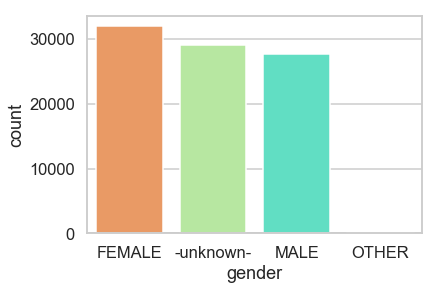

In [245]:
sns.countplot(users['gender'], palette = "rainbow_r")

#### Below I want to plot the age distribution in order have insights regarding the most frequent age among the users. 

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


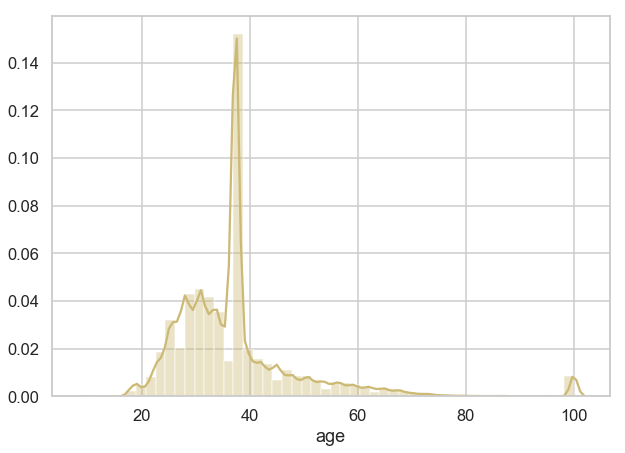

In [246]:
plt.figure(figsize=(10,7))
sns.distplot(users["age"], color="y")

- From the plot above I can clearly see that the majority of the users have around 40 years old. 

#### I will look if there is a trend in the dataset regarding the destinations choeesen by gender

In [142]:
female = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts().sum()
male = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts().sum()

In [143]:
female_destination = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / female*100
male_destionation = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / male*100

In [144]:
female_destination

US       70.934267
other     9.877161
FR        6.132592
IT        3.410121
GB        2.753727
ES        2.666208
CA        1.422186
DE        1.118995
NL        0.793924
AU        0.647017
PT        0.243803
Name: country_destination, dtype: float64

In [145]:
male_destination = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / male * 100

In [146]:
male_destination

US       70.188666
other    12.420187
FR        4.815844
IT        2.521554
GB        2.460229
ES        2.442192
CA        1.720717
DE        1.500667
NL        1.002850
AU        0.678186
PT        0.248909
Name: country_destination, dtype: float64

In [147]:
male_female_destination = pd.concat([female_destination,male_destination], axis =1)
male_female_destination.columns = ["female_destination","male_destination"]

In [148]:
male_female_destination

,female_destination,male_destination
US,70.934267,70.188666
other,9.877161,12.420187
FR,6.132592,4.815844
IT,3.410121,2.521554
GB,2.753727,2.460229
ES,2.666208,2.442192
CA,1.422186,1.720717
DE,1.118995,1.500667
NL,0.793924,1.002850
AU,0.647017,0.678186


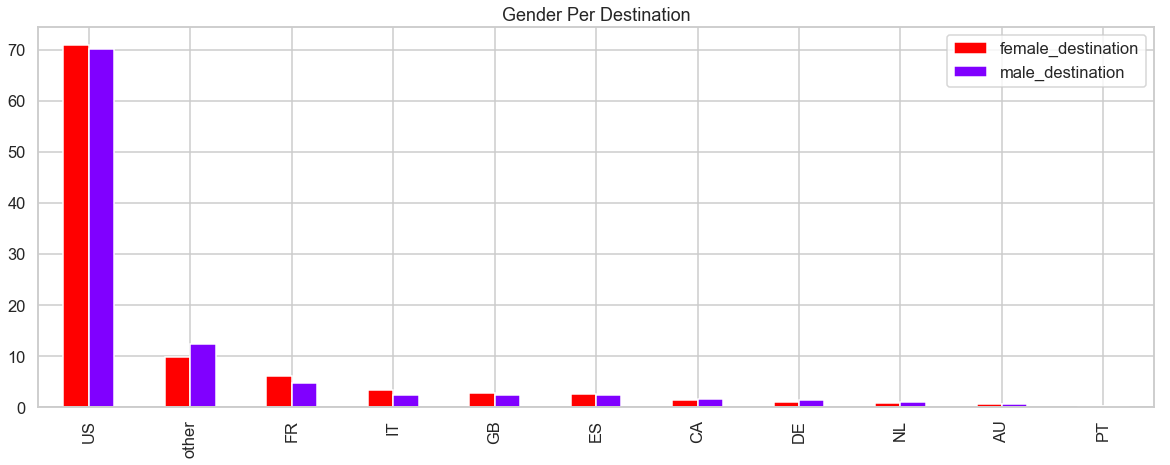

In [149]:
ax = male_female_destination.plot.bar(colormap = 'rainbow_r', title = 'Gender Per Destination',figsize = (20, 7))


- From the graph above I cannnot see a clear trend in choosing a country by gender

#### I want to see i there is a relationship between the signup_method and the country_destination

In [40]:
users["signup_method"].value_counts()

basic       65051
facebook    23756
google        101
Name: signup_method, dtype: int64

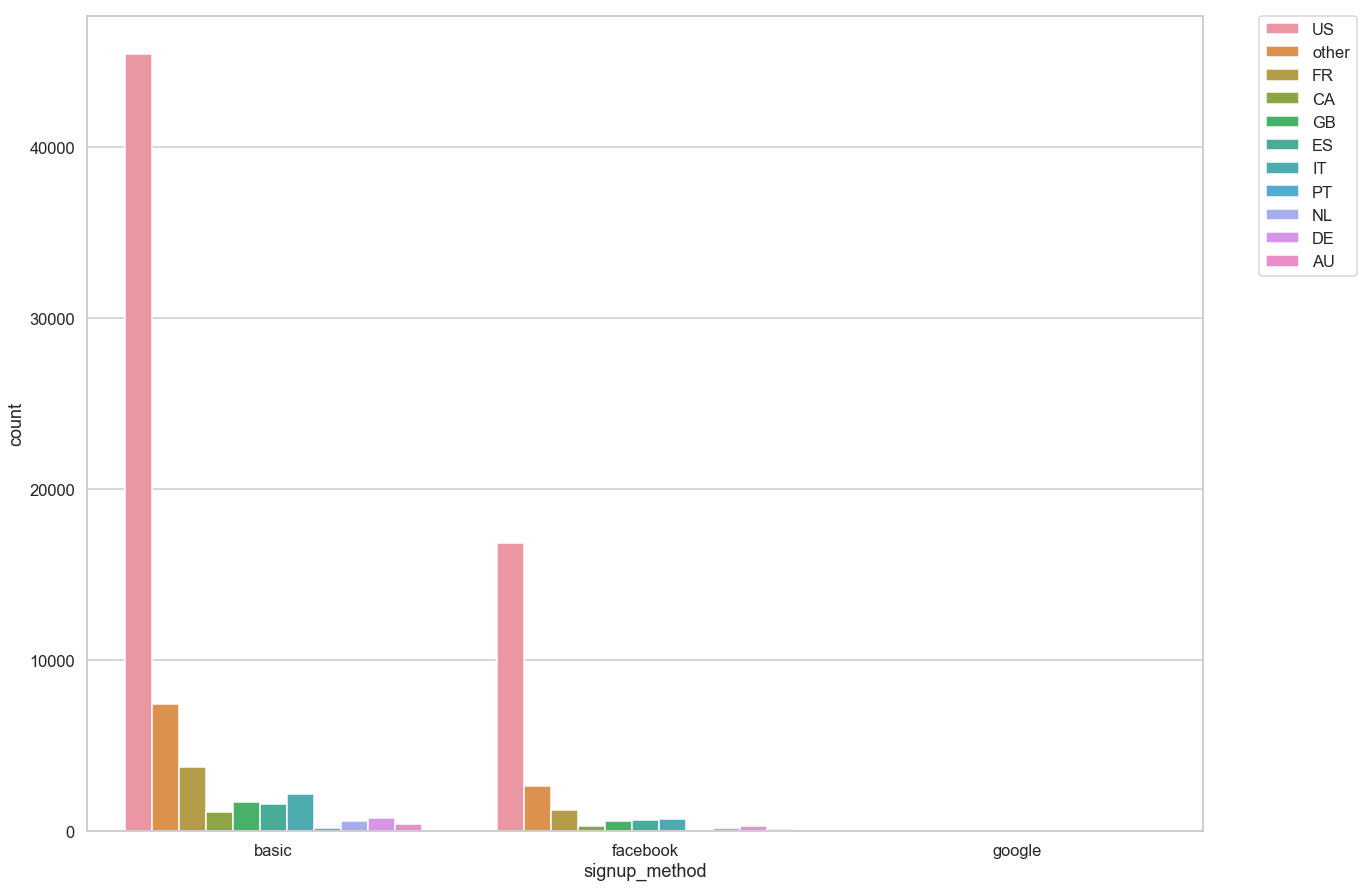

In [155]:
plt.figure(figsize=(20,15))
sns.countplot(users['signup_method'], hue=users['country_destination'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


- From the graph above seems that  by signing with the basic and facebook method, US is the country choosen by the mayority of the users 

#### I want to see i there is a relationship between the first_device_type and the country_destination

In [156]:
users["first_device_type"].value_counts()

Mac Desktop           42250
Windows Desktop       30152
iPhone                 6417
iPad                   5464
Other/Unknown          2875
Android Phone           715
Desktop (Other)         550
Android Tablet          460
SmartPhone (Other)       25
Name: first_device_type, dtype: int64

Visualization to see if there is a trend between the categorical variable "first_device_type" and the country of destination

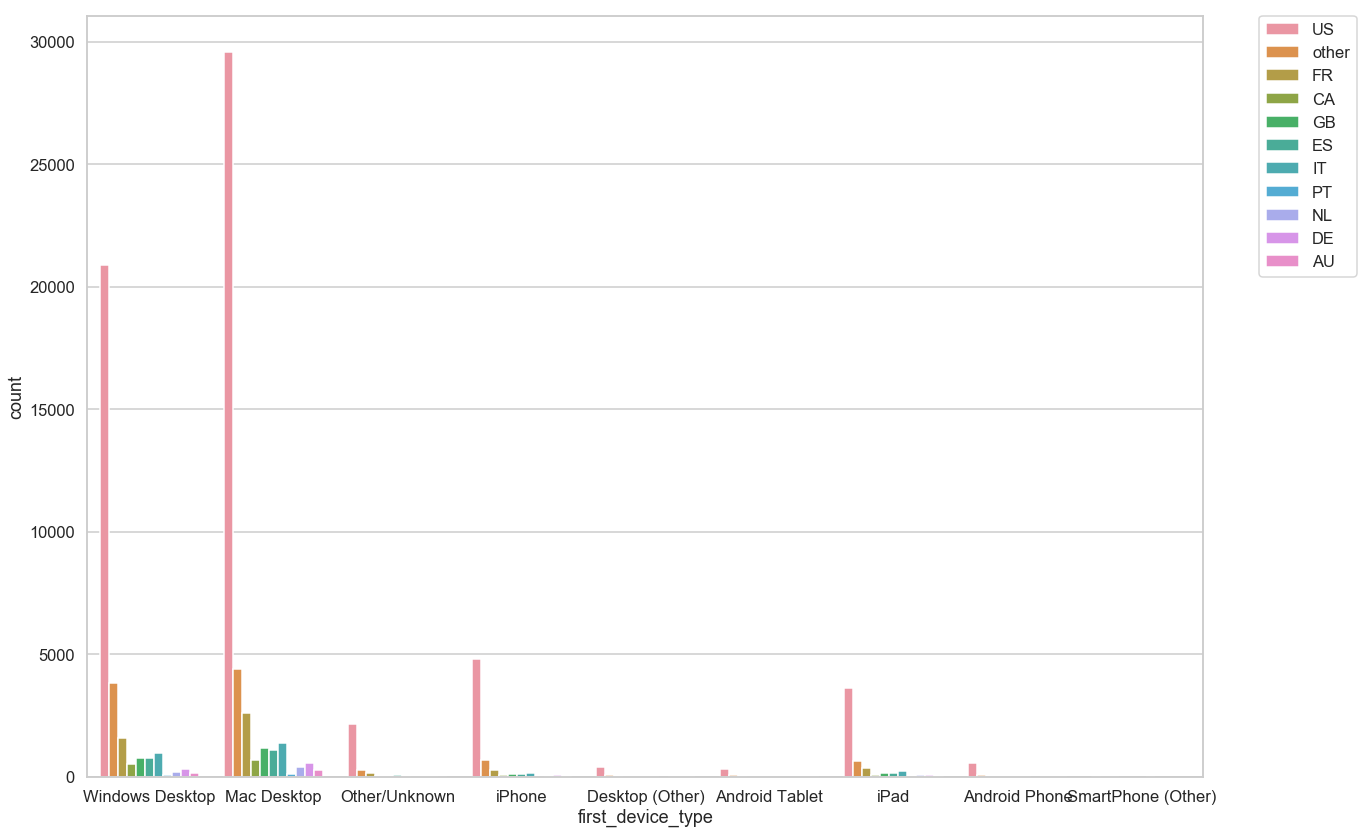

In [157]:
plt.figure(figsize=(20,14))
sns.countplot(users['first_device_type'], hue=users['country_destination'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


- From the graph above i can see that the most used devices are Mac Desktop and Windows Desktop and from both of them seems clear that US is the country most chosen 

## Feature Engeneering

#### Handleling Datetime Features & Visualization to see if there is a day of the week with signifiative number of new accounts created

In [158]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_account_created_hour'] = users.date_account_created.dt.hour
users['date_account_created_day'] = users.date_account_created.dt.weekday_name
users['date_account_created_month'] = users.date_account_created.dt.month
users['date_account_created_year'] = users.date_account_created.dt.year

users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')
users['date_first_active_hour'] = users.date_first_active.dt.hour
users['date_first_active_day'] = users.date_first_active.dt.weekday_name
users['date_first_active_month'] = users.date_first_active.dt.month
users['date_first_active_year'] = users.date_first_active.dt.year

users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_booking_hour'] = users.date_first_booking.dt.hour
users['date_first_booking_day'] = users.date_first_booking.dt.weekday_name
users['date_first_booking_month'] = users.date_first_booking.dt.month
users['date_first_booking_year'] = users.date_first_booking.dt.year

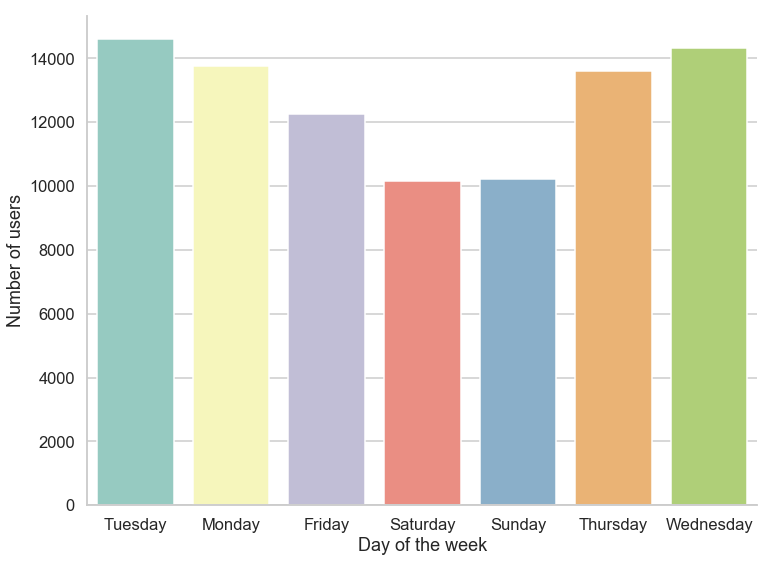

In [159]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.countplot(x='date_account_created_day',data=users, palette="Set3")
plt.xlabel('Day of the week')
plt.ylabel('Number of users')
sns.despine()

- From the plot above is possible to state that the 2 days with less numbers of new accounts crated are Saturday and Sunday. This insight can be extremely useful.

##### Sessions

In [160]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,435.0


#### First action

By performing the following feature engineering I will focus just on the first actions  each user will take in place

In [161]:
first_action = sessions.groupby(['user_id'])['action'].first().reset_index()
first_action_type = sessions.groupby(['user_id'])['action_type'].first().reset_index()
first_action_detail = sessions.groupby(['user_id'])['action_detail'].first().reset_index()
# I don't need to get the first device type because that info is already on the users data

In [162]:
first_action_detail.isnull().sum()

user_id          0
action_detail    5
dtype: int64

In [163]:
first_action.isna().sum()

user_id      0
action     440
dtype: int64

In [164]:
first_action_type.isna().sum()

user_id        0
action_type    5
dtype: int64

I create 3 new useful columns in which I can see for each id the `first_action`,`first_action_type` and the `first_action_detail`

In [165]:
first_0 = pd.merge(first_action, first_action_type, how='outer', on='user_id')
extra_data_0 = pd.merge(first_0, first_action_detail, how='outer', on='user_id')
extra_data_0.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail']
extra_data_0.head()

,id,first_action,first_action_type,first_action_detail
0,00023iyk9l,index,view,view_search_results
1,0010k6l0om,search_results,click,view_search_results
2,001wyh0pz8,search,click,view_search_results
3,0028jgx1x1,show,view,user_profile
4,002qnbzfs5,social_connections,data,user_social_connections


#### Last action

Now is time to focus on the last action a user will perform 

In [166]:
last_action = sessions.groupby(['user_id'])['action'].last().reset_index()
last_action_type = sessions.groupby(['user_id'])['action_type'].last().reset_index()
last_action_detail = sessions.groupby(['user_id'])['action_detail'].last().reset_index()
last_device_type = sessions.groupby(['user_id'])['device_type'].last().reset_index()


In [167]:
last_device_type.isnull().sum()

user_id        0
device_type    0
dtype: int64

I can now merge in a unique dataframe the first and the last actions and the features related in order to have a complete view 

In [168]:
extra_data_10 = pd.merge(extra_data_0, last_action, how='outer', left_on='id', right_on='user_id')
extra_data_1 = pd.merge(extra_data_10, last_action_type, how='outer', on='user_id')
extra_data_2 = pd.merge(extra_data_1, last_action_detail, how='outer', on='user_id')
extra_data_3 = pd.merge(extra_data_2, last_device_type, how='outer', on='user_id')
extra_data_3.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail','user_id',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type']
extra_data_3.head()

,id,first_action,first_action_type,first_action_detail,user_id,last_action,last_action_type,last_action_detail,last_device_type
0,00023iyk9l,index,view,view_search_results,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop
1,0010k6l0om,search_results,click,view_search_results,0010k6l0om,search_results,click,view_search_results,Mac Desktop
2,001wyh0pz8,search,click,view_search_results,001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet
3,0028jgx1x1,show,view,user_profile,0028jgx1x1,search,click,view_search_results,-unknown-
4,002qnbzfs5,social_connections,data,user_social_connections,002qnbzfs5,social_connections,data,user_social_connections,iPhone


#### Number of Actions

In [169]:
size_actions = sessions.groupby(['user_id']).size().reset_index()

In [170]:
extra_data_4 = pd.merge(extra_data_3, size_actions, how='outer', on='user_id')
extra_data_4.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail','user_id',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type',
                        '#actions']
extra_data_4.head()

,id,first_action,first_action_type,first_action_detail,user_id,last_action,last_action_type,last_action_detail,last_device_type,#actions
0,00023iyk9l,index,view,view_search_results,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,40
1,0010k6l0om,search_results,click,view_search_results,0010k6l0om,search_results,click,view_search_results,Mac Desktop,63
2,001wyh0pz8,search,click,view_search_results,001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet,90
3,0028jgx1x1,show,view,user_profile,0028jgx1x1,search,click,view_search_results,-unknown-,31
4,002qnbzfs5,social_connections,data,user_social_connections,002qnbzfs5,social_connections,data,user_social_connections,iPhone,789


#### Nunique

By performing the below feature engineering I will create new columns that are counting the unique actions performed by each user

In [171]:
nunique_action = sessions.groupby(['user_id'])['action'].nunique().reset_index()
nunique_action_type = sessions.groupby(['user_id'])['action_type'].nunique().reset_index()
nunique_action_detail = sessions.groupby(['user_id'])['action_detail'].nunique().reset_index()
nunique_device_type = sessions.groupby(['user_id'])['device_type'].nunique().reset_index()

In [172]:
extra_data_5 = pd.merge(extra_data_4, nunique_action, how='outer', on='user_id')
extra_data_6 = pd.merge(extra_data_5, nunique_action_type, how='outer', on='user_id')
extra_data_7 = pd.merge(extra_data_6, nunique_action_detail, how='outer', on='user_id')
extra_data_8 = pd.merge(extra_data_7, nunique_device_type, how='outer', on='user_id')
extra_data_8.drop(['user_id'], inplace=True, axis=1)
extra_data_8.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type',
                        '#actions',
                        'nunique_action', 'nunique_action_type', 'nunique_action_detail','nunique_device_type']
extra_data_8.head()

,id,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,00023iyk9l,index,view,view_search_results,personalize,data,wishlist_content_update,Mac Desktop,40,13,6,13,2
1,0010k6l0om,search_results,click,view_search_results,search_results,click,view_search_results,Mac Desktop,63,11,5,8,1
2,001wyh0pz8,search,click,view_search_results,search,click,view_search_results,Android App Unknown Phone/Tablet,90,10,5,9,1
3,0028jgx1x1,show,view,user_profile,search,click,view_search_results,-unknown-,31,5,5,6,2
4,002qnbzfs5,social_connections,data,user_social_connections,social_connections,data,user_social_connections,iPhone,789,25,7,22,2


### Users

In [173]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_account_created_hour,date_account_created_day,date_account_created_month,date_account_created_year,date_first_active,date_first_active_hour,date_first_active_day,date_first_active_month,date_first_active_year,date_first_booking_hour,date_first_booking_day,date_first_booking_month,date_first_booking_year
0,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0,Tuesday,9,2010,2009-06-09,0,Tuesday,6,2009,0,Monday,8,2010
1,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0,Monday,12,2011,2009-10-31,0,Saturday,10,2009,0,Saturday,9,2012
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0,Tuesday,9,2010,2009-12-08,0,Tuesday,12,2009,0,Thursday,2,2010
3,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,37.373563,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,0,Friday,1,2010,2010-01-01,0,Friday,1,2010,0,Saturday,1,2010
4,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.000000,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,0,Saturday,1,2010,2010-01-02,0,Saturday,1,2010,0,Tuesday,1,2010


#### Days Between Sign Up and First Booking

I will create a new column in the data frame `users` that  is the result of the gap between the `date_account_created` and `date_first_booking`

In [174]:
users['date_account_created'] = pd.to_datetime(users.date_account_created)
users['date_first_booking'] = pd.to_datetime(users.date_first_booking)

In [175]:
users['days_before_first_booking'] = (users['date_first_booking'] - users['date_account_created']).dt.days 

### Merge

Now I will finally merge all the new columns created with the data frame `users` in order to create my very final data frame `final users`

In [176]:
users.shape

(88908, 30)

In [177]:
extra_data_8.shape

(135483, 13)

In [178]:
users.id.nunique()

88908

In [179]:
final_users = pd.merge(users, extra_data_8, how='inner', on='id')
final_users.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_account_created_hour,date_account_created_day,date_account_created_month,date_account_created_year,date_first_active,date_first_active_hour,date_first_active_day,date_first_active_month,date_first_active_year,date_first_booking_hour,date_first_booking_day,date_first_booking_month,date_first_booking_year,days_before_first_booking,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.000000,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,0,Saturday,1,2014,3,lookup,lookup,lookup,show,view,p3,Windows Desktop,127,16,7,10,2
1,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,37.373563,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,0,Thursday,1,2014,1,campaigns,-unknown-,-unknown-,index,-unknown-,-unknown-,iPhone,8,7,1,1,1
2,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.000000,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,0,Tuesday,1,2014,6,dashboard,view,dashboard,confirm_email,click,confirm_email_link,iPhone,7,4,5,5,2
3,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.000000,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,other,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,0,Thursday,12,2014,337,similar_listings,data,similar_listings,ajax_refresh_subtotal,click,change_trip_characteristics,Mac Desktop,43,12,7,11,1
4,awiurksqr3,2014-01-01,20140101010113,2014-01-02,FEMALE,32.000000,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,US,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,0,Thursday,1,2014,1,ask_question,submit,contact_host,confirm_email,click,confirm_email_link,iPhone,8,7,6,8,2


In [180]:
final_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking              0
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked         5
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
date_account_created_hour       0
date_account_created_day        0
date_account_created_month      0
date_account_created_year       0
date_first_active               0
date_first_active_hour          0
date_first_active_day           0
date_first_active_month         0
date_first_active_year          0
date_first_booking_hour         0
date_first_booking_day          0
date_first_booking_month        0
date_first_booking_year         0
days_before_fi

## DATA CLEANING 

I will perfrom data cleaning on my `final users` dataset, which is the final dataset that I will use to perform my analisys.
This dataset is the result of the merge of the initial data set `users` and the new columns that I've created by feature engeeniering few columns of the `sessions` data set.

Using the isnull() function I can see that some of the features have nulls values. I will inspect each by each and I will take action on the nulls values.  

In [181]:
final_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking              0
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked         5
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
date_account_created_hour       0
date_account_created_day        0
date_account_created_month      0
date_account_created_year       0
date_first_active               0
date_first_active_hour          0
date_first_active_day           0
date_first_active_month         0
date_first_active_year          0
date_first_booking_hour         0
date_first_booking_day          0
date_first_booking_month        0
date_first_booking_year         0
days_before_fi

In [182]:
100*final_users["date_first_booking"].isna().sum()/len(final_users)

0.0

In [183]:
100*final_users["days_before_first_booking"].isna().sum()/len(final_users)

0.0

I can clearly see that the features related with `date_first_booking` have more than the 60% of null values so I decide to drop thoose columns from the data frame `data_fin`, even though I've created days_before_first_booking by my self by performing feature engineering. 

In [184]:
final_users.drop(['date_first_booking',"days_before_first_booking",'date_first_booking_hour',
              'date_first_booking_day','date_first_booking_year','date_first_booking_month'], 
              axis=1, inplace=True)


In [185]:
final_users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_account_created_hour,date_account_created_day,date_account_created_month,date_account_created_year,date_first_active,date_first_active_hour,date_first_active_day,date_first_active_month,date_first_active_year,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,d1mm9tcy42,2014-01-01,20140101000936,MALE,62.000000,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,lookup,lookup,lookup,show,view,p3,Windows Desktop,127,16,7,10,2
1,4rvqpxoh3h,2014-01-01,20140101002619,-unknown-,37.373563,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,campaigns,-unknown-,-unknown-,index,-unknown-,-unknown-,iPhone,8,7,1,1,1
2,xwxei6hdk4,2014-01-01,20140101002742,FEMALE,32.000000,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,dashboard,view,dashboard,confirm_email,click,confirm_email_link,iPhone,7,4,5,5,2
3,ro2stddszp,2014-01-01,20140101005503,-unknown-,19.000000,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,other,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,similar_listings,data,similar_listings,ajax_refresh_subtotal,click,change_trip_characteristics,Mac Desktop,43,12,7,11,1
4,awiurksqr3,2014-01-01,20140101010113,FEMALE,32.000000,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,US,0,Wednesday,1,2014,2014-01-01,0,Wednesday,1,2014,ask_question,submit,contact_host,confirm_email,click,confirm_email_link,iPhone,8,7,6,8,2


###### Dummies

In [186]:
# I drop the first colum for all the dummies so I don't have multicolinearity
users_dummies = pd.get_dummies(final_users[['gender',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser','first_action', 'first_action_type', 'first_action_detail',
       'last_action', 'last_action_type', 'last_action_detail',
       'last_device_type',
       'date_account_created_hour','date_account_created_month','date_account_created_day',
       'date_first_active_hour','date_first_active_month','date_first_active_day']],
                               drop_first=True).reset_index(drop=True)
print(users_dummies.columns)
users_dummies.shape

Index(['signup_flow', 'date_account_created_hour',
       'date_account_created_month', 'date_first_active_hour',
       'date_first_active_month', 'gender_FEMALE', 'gender_MALE',
       'gender_OTHER', 'signup_method_facebook', 'signup_method_google',
       ...
       'date_account_created_day_Sunday', 'date_account_created_day_Thursday',
       'date_account_created_day_Tuesday',
       'date_account_created_day_Wednesday', 'date_first_active_day_Monday',
       'date_first_active_day_Saturday', 'date_first_active_day_Sunday',
       'date_first_active_day_Thursday', 'date_first_active_day_Tuesday',
       'date_first_active_day_Wednesday'],
      dtype='object', length=755)


(28774, 755)

In [187]:
# Dropping the original categorical columns that now I have as dummies
final_users_without_cat = final_users.drop(['gender',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser','first_action', 'first_action_type', 'first_action_detail',
       'last_action', 'last_action_type', 'last_action_detail',
       'last_device_type',
       'date_account_created_hour','date_account_created_month','date_account_created_day',
       'date_first_active_hour','date_first_active_month','date_first_active_day'], axis=1).reset_index(drop=True) 

data_fin = pd.concat([final_users_without_cat, users_dummies], axis=1)
data_fin.head()

,id,date_account_created,timestamp_first_active,age,country_destination,date_account_created_year,date_first_active,date_first_active_year,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type,signup_flow,date_account_created_hour,date_account_created_month,date_first_active_hour,date_first_active_month,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hu,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_BlackBerry Browser,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CoolNovo,first_browser_Firefox,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceWeasel,first_browser_Iron,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Opera,first_browser_Opera Mini,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_wOSBrowser,first_action_11,first_action_12,first_action_15,first_action_about_us,first_action_account,first_action_active,first_action_add_note,first_action_agree_terms_check,first_action_airbnb_picks,first_action_ajax_check_dates,first_action_ajax_get_referrals_amt,first_action_ajax_get_results,first_action_ajax_google_translate_description,first_action_ajax_google_translate_reviews,first_action_ajax_image_upload,first_action_ajax_lwlb_contact,first_action_ajax_payout_options_by_country,first_action_ajax_photo_widget_form_iframe,first_action_ajax_referral_banner_experiment_type,first_action_ajax_referral_banner_type,first_action_ajax_refresh_subtotal,first_action_ajax_statsd,first_action_apply_code,first_action_apply_coupon_click,first_action_apply_coupon_click_success,first_action_apply_coupon_error,first_action_apply_coupon_error_type,first_action_apply_reservation,first_action_ask_question,first_action_at_checkpoint,first_action_authenticate,first_action_authorize,first_action_available,first_action_calendar_tab_inner2,first_action_callback,first_action_campaigns,first_action_cancel,first_action_cancellation_policies,first_action_cancellation_policy_click,first_action_change,first_action_change_currency,first_action_click,first_action_clickthrough,first_action_collections,first_action_complete,first_action_complete_redirect,first_action_complete_status,first_action_concierge,first_action_confirm_email,first_action_connect,first_action_contact_new,first_action_coupon_code_click,first_action_coupon_field_focus,first_action_create,first_act

# Modelling


The nature of my data set and the target variable `country_destination` can be targeted as a multiclass classification problem. However, due to the shortage of time and to the complexity of the problem, I've decided to consider the problem as a binary classification. The scope of the modelling is to predic wheather a new user will go in the `US` or not. I choose the US as a target varible becouse from my EDA I found out that the `US` was the most choosen country by the existing users. 

In [188]:
data_fin["US"] = (data_fin["country_destination"] == "US").astype(int)

In [189]:
(data_fin["US"].value_counts(normalize=True) * 100).round().astype(int)# 70% of existing users are choosing US 

1    70
0    30
Name: US, dtype: int64

From the result above I can clearly see that there is class imbalance issue. In the future I will solve the 
by applying Synthetic Minority Oversampling(SMOTE). By using SMOTE technique the algorithm will generate new sample data by creating 'synthetic' examples that are the combinations of the closest minority class cases.

In [227]:
X = data_fin.drop(
    ["country_destination",'date_account_created','date_first_active','timestamp_first_active','id','US'],
    axis=1) 
y = data_fin["US"] # my target variable 

In [228]:
from imblearn.over_sampling import SMOTE

In [229]:
# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
# Create validation set
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [194]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    20095
0     8679
Name: US, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    17005
0    17005
Name: US, dtype: int64


Now the target variable is equally divided in two classes of 17005 observations each. 

In [234]:
print(len(X_train_resampled))
print(len(X_test))
print(len(X_val))

24457
4317
3669


I will use the funcions below for simplify my modelling 

In [197]:
def scores(model, X_train_v, X_val, y_train_v, y_val):
    """
    This function allows me to view the train and val Area under the curve scores
    """
    train_prob = model.predict_proba(X_train_v)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    train = roc_auc_score(y_train_v, train_prob)
    val = roc_auc_score(y_val, val_prob)
    print('ROC_AUC',"train_v:", round(train, 3), "val:", round(val, 3))

In [198]:
def roc_plot(model, X_train, y_train, X_val, y_val):
    """"
    This function allows us to plot our roc curve based off our predicted probabilities from our Train and validation sets
    """
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    plt.figure(figsize=(7, 7))
    for data in [[y_train, train_prob], [y_val, val_prob]]:  # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.ylabel("TPR (power)")
    plt.xlabel("FPR (alpha)")
    plt.legend(["train", "test"])
    plt.show()

## Logistic regression

My project has to deal with a multiclass classification problem so I decide to run as a baseline model a simple logistic regression. For the baseline model I will consider all the columns of the final dataframe, except the datetimes because they are machine learning models are not good to handle them and also I have already extract their meanningful information in other columns (hour, year, day of the week, month). In addiction I will also drop `timestamp_first_active` because I already extract the relevant information from it. I will need to drop `id` aswell because it is not meaningful.

### Baseline Model

In [199]:
baseline_model = LogisticRegression(fit_intercept=True, random_state=42, max_iter=1000)
baseline_model.fit(X_train_v, y_train_v)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [200]:
scores(baseline_model, X_train_v, X_val, y_train_v, y_val)


ROC_AUC train_v: 0.587 val: 0.584


The model has to be improved as the result of the ROC_AUC is not really hight. 

### Hyperparameter tuning

In [203]:
params_grid = {'penalty':['l1','l2']}
# 'C':[1,10,100],

In [204]:
skf = StratifiedKFold(n_splits = 3, random_state = 600, shuffle=True)


opt_model_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=500,
                                           solver='liblinear', C=1e8),
                         params_grid,
                         cv=skf,
                         scoring='roc_auc',
                         return_train_score=True,
                         verbose=2,
                         n_jobs=-1)

opt_model_lr.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=600, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=100000000.0, class_weight=None,
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=2)

In [205]:
print('best params', opt_model_lr.best_params_)
print()
print('best estimator', opt_model_lr.best_estimator_)
print()
print('best params', round(opt_model_lr.best_score_, 3)) # roc_auc cross validation score)
print()
pd.DataFrame(opt_model_lr.cv_results_)

best params {'penalty': 'l2'}

best estimator LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

best params 0.573



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.045332,0.313919,0.082809,0.011656,l1,{'penalty': 'l1'},0.566663,0.558798,0.562352,0.562604,0.003216,2,0.633898,0.641355,0.639559,0.638271,0.003178
1,1.400733,0.208199,0.099824,0.041494,l2,{'penalty': 'l2'},0.572863,0.572493,0.574882,0.573413,0.001050,1,0.587659,0.585809,0.596903,0.590124,0.004853


## K NEAREST NEIGHBOURS

### Basic Model

In [214]:
knn_clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, metric="euclidean")
knn_clf.fit(X_train_v, y_train_v)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='uniform')

In [215]:
scores(knn_clf, X_train_v, X_val, y_train_v, y_val)

ROC_AUC train_v: 0.711 val: 0.538


Whith the KNN basic model I can see that the result of the ROC_AUC of the train_v is much higher(0.711) than the one obtained from the Logistic Regression basic model (0.587). However I can see that the KNN basic model is higly overfitted and this make it a much more worse model. 

### Hyperparameter Tuning

In [216]:
param_grid_knn = {
    "n_neighbors": [5, 10, 20],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

In [217]:
opt_model_knn = GridSearchCV(knn_clf,
                             param_grid_knn, 
                             cv=skf, 
                             scoring='roc_auc',
                             return_train_score=True)
opt_model_knn.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=600, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='euclidean',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=10, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 10, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [218]:
print('best params', opt_model_knn.best_params_)
print()
print('best estimator', opt_model_knn.best_estimator_)
print()
print('best params', round(opt_model_knn.best_score_, 3)) # roc_auc cross validation score
print()
pd.DataFrame(opt_model_knn.cv_results_)

best params {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}

best estimator KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                     weights='distance')

best params 0.546



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.374859,0.252995,5.284521,1.093313,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.523595,0.535748,0.535965,0.531769,0.005780,12,0.782690,0.779309,0.780743,0.780914,1.385264e-03
1,1.040174,0.024842,3.687577,0.118137,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.524768,0.539364,0.538207,0.534113,0.006625,10,1.000000,1.000000,1.000000,1.000000,4.185074e-09
2,1.019722,0.011865,4.112154,0.192722,euclidean,10,uniform,"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.537627,0.540484,0.539169,0.539093,0.001168,7,0.715810,0.705615,0.709422,0.710282,4.206511e-03
3,1.014630,0.001823,3.913261,0.028448,euclidean,10,distance,"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.537740,0.544883,0.541582,0.541402,0.002919,5,1.000000,1.000000,1.000000,1.000000,4.185074e-09
4,1.011109,0.002087,4.286212,0.037512,euclidean,20,uniform,"{'metric': 'euclidean', 'n_neighbors': 20, 'we...",0.538715,0.545185,0.545583,0.543161,0.003148,3,0.663771,0.656320,0.655220,0.658437,3.798091e-03
5,1.025304,0.018866,4.280007,0.050544,euclidean,20,distance,"{'metric': 'euclidean', 'n_neighbors': 20, 'we...",0.540826,0.548183,0.547706,0.545572,0.003361,1,1.000000,1.000000,1.000000,1.000000,4.185074e-09
6,1.038588,0.018229,10.687961,1.048597,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.530965,0.542165,0.527699,0.533610,0.006194,11,0.789176,0.777554,0.782097,0.782943,4.782219e-03
7,1.308361,0.269959,11.325327,0.824072,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.531232,0.543542,0.532768,0.535848,0.005477,9,1.000000,1.000000,1.000000,1.000000,4.185074e-09
8,1.378683,0.330898,20.387847,6.043858,manhattan,10,uniform,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.530036,0.544386,0.537603,0.537342,0.005861,8,0.722568,0.709035,0.713021,0.714874,5.678435e-03
9,1.164603,0.167160,14.738944,2.527076,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.532473,0.547276,0.540202,0.539984,0.006045,6,1.000000,1.000000,1.000000,1.000000,4.185074e-09


## Decision Tree

###  Basic

In [219]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=140)

In [220]:
tree_clf.fit(X_train_v, y_train_v)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

In [221]:
scores(tree_clf, X_train_v, X_val, y_train_v, y_val)

ROC_AUC train_v: 0.558 val: 0.559


### Hyperparameter Tunning 

In [222]:
#Establishing the parameter grid

param_grid_dt = {'max_depth': range(1,5), 'min_samples_leaf': [1,5,10,15]}

In [223]:
opt_model_dt = GridSearchCV(DecisionTreeClassifier(random_state=55, class_weight='balanced'), 
                           param_grid_dt,
                           cv=skf,  
                           scoring='roc_auc', 
                           return_train_score=True)


In [224]:
opt_model_dt.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=600, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=55,
                                              splitter='best'),
 

In [226]:
print('best params', opt_model_dt.best_params_)
print()
print('best estimator', opt_model_dt.best_estimator_)
print()
print('best params', round(opt_model_dt.best_score_, 3)) # roc_auc cross validation score
print()
pd.DataFrame(opt_model_dt.cv_results_)

best params {'max_depth': 4, 'min_samples_leaf': 1}

best estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=55, splitter='best')

best params 0.563



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.220403,0.021596,0.043579,0.005033,1,1,"{'max_depth': 1, 'min_samples_leaf': 1}",0.518215,0.524184,0.532501,0.524967,0.005859,13,0.526457,0.523472,0.536372,0.528767,0.005514
1,0.245728,0.070450,0.053019,0.024392,1,5,"{'max_depth': 1, 'min_samples_leaf': 5}",0.518215,0.524184,0.532501,0.524967,0.005859,13,0.526457,0.523472,0.536372,0.528767,0.005514
2,0.250985,0.061061,0.043235,0.009614,1,10,"{'max_depth': 1, 'min_samples_leaf': 10}",0.518215,0.524184,0.532501,0.524967,0.005859,13,0.526457,0.523472,0.536372,0.528767,0.005514
3,0.237438,0.035954,0.048725,0.018621,1,15,"{'max_depth': 1, 'min_samples_leaf': 15}",0.518215,0.524184,0.532501,0.524967,0.005859,13,0.526457,0.523472,0.536372,0.528767,0.005514
4,0.315039,0.012098,0.049917,0.003907,2,1,"{'max_depth': 2, 'min_samples_leaf': 1}",0.539676,0.530452,0.561625,0.543918,0.013075,9,0.556142,0.534464,0.556336,0.548981,0.010265
5,0.284237,0.005622,0.044417,0.004201,2,5,"{'max_depth': 2, 'min_samples_leaf': 5}",0.539676,0.530452,0.561625,0.543918,0.013075,9,0.556142,0.534464,0.556336,0.548981,0.010265
6,0.281871,0.001504,0.044268,0.004329,2,10,"{'max_depth': 2, 'min_samples_leaf': 10}",0.539676,0.530452,0.561625,0.543918,0.013075,9,0.556142,0.534464,0.556336,0.548981,0.010265
7,0.287611,0.002777,0.046695,0.005395,2,15,"{'max_depth': 2, 'min_samples_leaf': 15}",0.539676,0.530452,0.561625,0.543918,0.013075,9,0.556142,0.534464,0.556336,0.548981,0.010265
8,0.344406,0.012176,0.045908,0.002804,3,1,"{'max_depth': 3, 'min_samples_leaf': 1}",0.552480,0.560255,0.567947,0.560227,0.006315,5,0.581159,0.561674,0.565683,0.569505,0.008401
9,0.345307,0.008910,0.045668,0.003443,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.552480,0.560255,0.567947,0.560227,0.006315,5,0.581159,0.561674,0.565683,0.569505,0.008401


# Evaluation

By looking at the results of the ROC_AUC, that is the evaluator that i choose to use,  I can see that the 3 models that I performed are given a very similar result. However, as my goal is  to choose the best model, I can see that the result given by the Logistic Regression tuned with hyperparameter is slightly higher(0.573) than the other models. By saying that I choose as a final winning model the Logistic Regression tuned becouse, using the ROC_AUC as a evaluator, I get with this model the highest result. 